#New plan

In [ ]:
!pip install numpy pandas matplotlib scikit-learn xgboost tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 944.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.7 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.


In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd

# Fetch silver prices (symbol: 'SI=F'), gold (GC=F), USD index (DX-Y.NYB)
start_date = '1995-01-01'
end_date = '2025-10-14'  # today

# Fetch 'Close' price and flatten the column names
df = yf.download(['SI=F', 'GC=F', 'DX-Y.NYB'], start=start_date, end=end_date, auto_adjust=False)['Close']
df.columns = ['silver', 'gold', 'usd_index']

# Ensure the index is a DatetimeIndex
df.index = pd.to_datetime(df.index)

df = df.dropna()
print(df.head())

[*********************100%***********************]  3 of 3 completed

                silver        gold  usd_index
Date                                         
2000-08-30  112.139999  273.899994      4.930
2000-08-31  112.599998  278.299988      5.003
2000-09-01  111.419998  277.000000      5.004
2000-09-05  112.410004  275.799988      4.998
2000-09-06  114.120003  274.200012      4.983


In [ ]:
# Check for missing values
print(df.isnull().sum())
df = df.dropna()  # Drop rows with missing data

# Scale features for LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


silver       0
gold         0
usd_index    0
dtype: int64


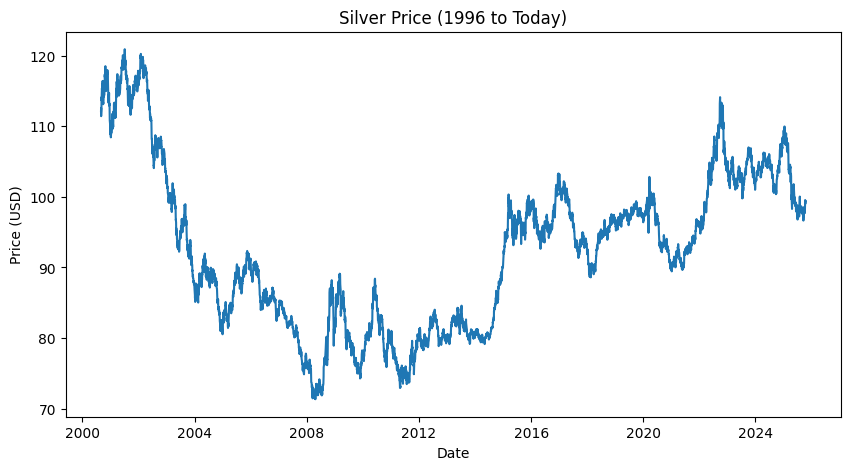

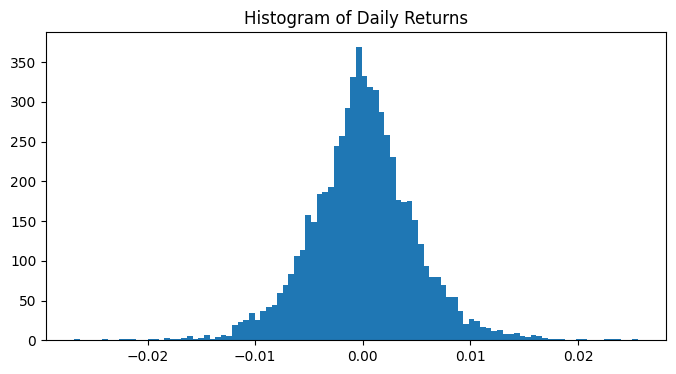

Correlation matrix:
           silver   gold  usd_index
silver      1.000  0.037     -0.272
gold        0.037  1.000      0.881
usd_index  -0.272  0.881      1.000


In [ ]:
# Plot silver price over time
plt.figure(figsize=(10,5))
plt.plot(df.index, df['silver'])
plt.title('Silver Price (1996 to Today)')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.show()

# Distribution of daily returns
returns = df['silver'].pct_change()
plt.figure(figsize=(8,4))
plt.hist(returns.dropna(), bins=100)
plt.title('Histogram of Daily Returns')
plt.show()

# Correlations between silver, gold, and USD index
print("Correlation matrix:")
print(df[['silver', 'gold', 'usd_index']].corr().round(3))


In [ ]:
import numpy as np

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predict silver price
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)


In [ ]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



Epoch 1/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 0.0222 - val_loss: 3.7200e-04
Epoch 2/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 5.0785e-04 - val_loss: 3.9747e-04
Epoch 3/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 4.4370e-04 - val_loss: 2.7518e-04
Epoch 4/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 4.2775e-04 - val_loss: 3.1323e-04
Epoch 5/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 3.8002e-04 - val_loss: 3.3663e-04
Epoch 6/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - loss: 3.9807e-04 - val_loss: 2.3723e-04
Epoch 7/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 3.2409e-04 - val_loss: 2.2276e-04
Epoch 8/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - loss: 3.6176e-04 - val_loss: 2.0177e-04
Epoch 9/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 2.7708e-04 - val_loss: 8.4326e-04
Epoch 10/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 2.8456e-04 - val_loss: 2.8683e-04
Epoch 11/30
141/141 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/

In [ ]:
y_pred_lstm = model.predict(X_test)

# Add print statements to check shapes
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')
print(f'Shape of y_pred_lstm: {y_pred_lstm.shape}')
print(f'Shape of y_pred_lstm.flatten(): {y_pred_lstm.flatten().shape}')


residuals = y_test - y_pred_lstm.flatten()

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Shape of X_test: (1248, 60, 3)
Shape of y_test: (1248,)
Shape of y_pred_lstm: (1248, 1)
Shape of y_pred_lstm.flatten(): (1248,)


In [ ]:
import xgboost as xgb

# Features for XGBoost: last day in sequence gold & USD index
X_xgb = X_test[:, -1, 1:]  # exclude silver

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200)
xgb_model.fit(X_xgb, residuals)

# Predict residuals
residuals_pred = xgb_model.predict(X_xgb)
final_pred = y_pred_lstm.flatten() + residuals_pred


Mean Squared Error: 1.945375299759382e-05


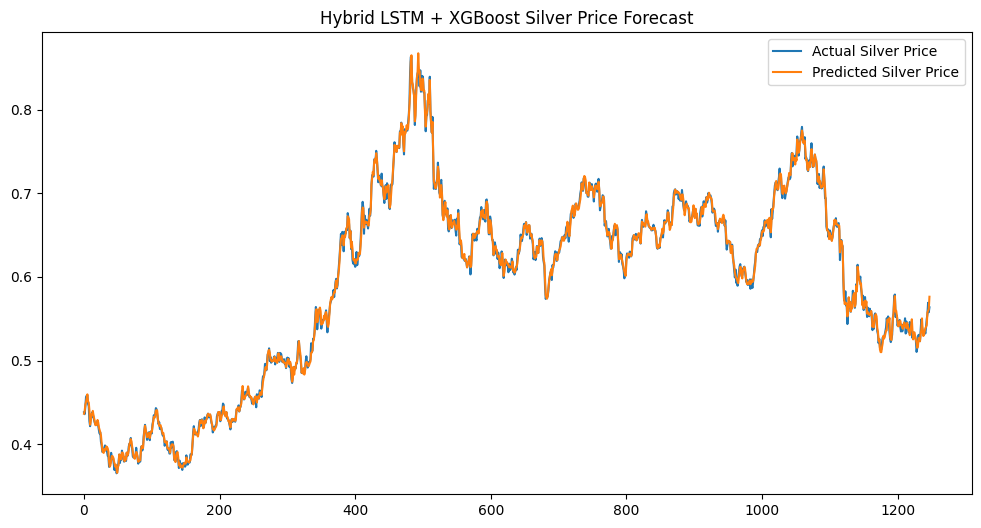

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, final_pred)
print(f'Mean Squared Error: {mse}')

plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual Silver Price')
plt.plot(final_pred, label='Predicted Silver Price')
plt.title('Hybrid LSTM + XGBoost Silver Price Forecast')
plt.legend()
plt.show()


In [ ]:
# Resample daily data to monthly average to smooth long-term trends
df_monthly = df.resample('M').mean()

# Scale monthly data
scaled_monthly = scaler.fit_transform(df_monthly)

# Create sequences for LSTM
X_monthly, y_monthly = create_sequences(scaled_monthly, seq_length=12)  # 12 months sequence


WARNING - (py.warnings._showwarnmsg) - /tmp/ipython-input-3346726094.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()

  df_monthly = df.resample('M').mean()



In [ ]:
train_size = int(len(X_monthly) * 0.8)
X_train_m, X_test_m = X_monthly[:train_size], X_monthly[train_size:]
y_train_m, y_test_m = y_monthly[:train_size], y_monthly[train_size:]


In [ ]:
model_m = Sequential()
model_m.add(LSTM(50, return_sequences=True, input_shape=(X_train_m.shape[1], X_train_m.shape[2])))
model_m.add(LSTM(50))
model_m.add(Dense(1))

model_m.compile(optimizer='adam', loss='mean_squared_error')
model_m.fit(X_train_m, y_train_m, epochs=30, batch_size=8, validation_split=0.1)


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)

  super().__init__(**kwargs)



Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0635 - val_loss: 0.0057
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0105 - val_loss: 0.0028
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0095 - val_loss: 0.0111
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0098 - val_loss: 0.0033
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0084 - val_loss: 0.0032
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0088 - val_loss: 0.0036
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0059 - val_loss: 0.0031
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0057 - val_loss: 0.0029
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0066 - val_loss: 0.0027
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0062 - val_loss: 0.0024
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0

In [ ]:
def recursive_forecast(model, x_last_seq, steps, xgb_model=None):
    """
    Forecast multiple future steps recursively
    x_last_seq: last sequence (seq_length, features)
    steps: number of future months to predict
    xgb_model: optional, XGBoost to correct residuals
    """
    forecast = []
    seq = x_last_seq.copy()

    for _ in range(steps):
        # Predict LSTM
        pred = model.predict(seq[np.newaxis, :, :])[0,0]

        # XGBoost residual correction (using last known gold & usd_index)
        if xgb_model:
            x_xgb = seq[-1, 1:].reshape(1,-1)
            res = xgb_model.predict(x_xgb)[0]
            pred += res

        forecast.append(pred)

        # Append predicted silver + last gold & usd_index for next step
        new_step = seq[-1].copy()
        new_step[0] = pred  # update silver
        seq = np.vstack([seq[1:], new_step])

    return np.array(forecast)


In [ ]:
# Use last available monthly sequence
last_seq = scaled_monthly[-12:]  # last 12 months

# Forecast horizons
steps_1yr = 12
steps_2yr = 24
steps_5yr = 60

forecast_1yr = recursive_forecast(model_m, last_seq, steps_1yr, xgb_model)
forecast_2yr = recursive_forecast(model_m, last_seq, steps_2yr, xgb_model)
forecast_5yr = recursive_forecast(model_m, last_seq, steps_5yr, xgb_model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

In [ ]:
# Create dummy array to inverse transform
def inverse_scale(scaled_values, scaler):
    dummy = np.zeros((len(scaled_values), scaled_monthly.shape[1]))
    dummy[:,0] = scaled_values  # silver column
    original = scaler.inverse_transform(dummy)
    return original[:,0]

forecast_1yr_orig = inverse_scale(forecast_1yr, scaler)
forecast_2yr_orig = inverse_scale(forecast_2yr, scaler)
forecast_5yr_orig = inverse_scale(forecast_5yr, scaler)


WARNING - (py.warnings._showwarnmsg) - /tmp/ipython-input-1254590633.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates_1yr = pd.date_range(last_date + pd.DateOffset(months=1), periods=12, freq='M')

  dates_1yr = pd.date_range(last_date + pd.DateOffset(months=1), periods=12, freq='M')

WARNING - (py.warnings._showwarnmsg) - /tmp/ipython-input-1254590633.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates_2yr = pd.date_range(last_date + pd.DateOffset(months=1), periods=24, freq='M')

  dates_2yr = pd.date_range(last_date + pd.DateOffset(months=1), periods=24, freq='M')

WARNING - (py.warnings._showwarnmsg) - /tmp/ipython-input-1254590633.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates_5yr = pd.date_range(last_date + pd.DateOffset(months=1), periods=60, freq='M')

  dates_5yr = pd.date_range(last_date 

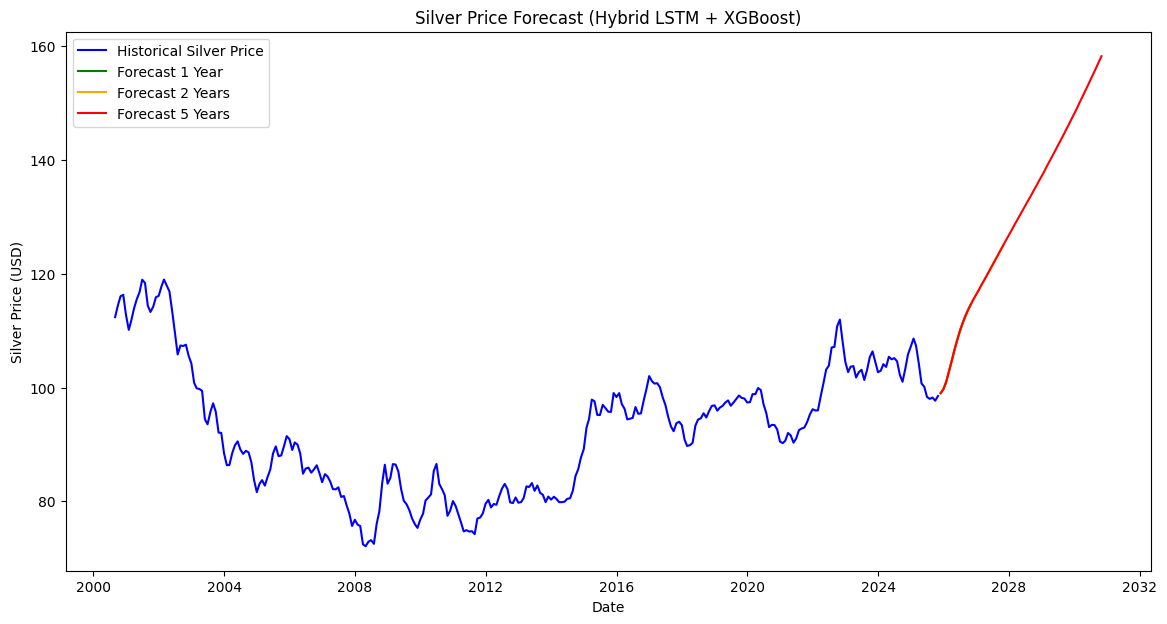

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dates for forecast
last_date = df_monthly.index[-1]
dates_1yr = pd.date_range(last_date + pd.DateOffset(months=1), periods=12, freq='M')
dates_2yr = pd.date_range(last_date + pd.DateOffset(months=1), periods=24, freq='M')
dates_5yr = pd.date_range(last_date + pd.DateOffset(months=1), periods=60, freq='M')

plt.figure(figsize=(14,7))
plt.plot(df_monthly['silver'], label='Historical Silver Price', color='blue')
plt.plot(dates_1yr, forecast_1yr_orig, label='Forecast 1 Year', color='green')
plt.plot(dates_2yr, forecast_2yr_orig, label='Forecast 2 Years', color='orange')
plt.plot(dates_5yr, forecast_5yr_orig, label='Forecast 5 Years', color='red')
plt.title('Silver Price Forecast (Hybrid LSTM + XGBoost)')
plt.xlabel('Date')
plt.ylabel('Silver Price (USD)')
plt.legend()
plt.show()


In [ ]:
# Create DataFrames for each forecast
df_forecast_1yr = pd.DataFrame({
    'Date': dates_1yr,
    'Silver_Price_USD': forecast_1yr_orig
})

df_forecast_2yr = pd.DataFrame({
    'Date': dates_2yr,
    'Silver_Price_USD': forecast_2yr_orig
})

df_forecast_5yr = pd.DataFrame({
    'Date': dates_5yr,
    'Silver_Price_USD': forecast_5yr_orig
})

# Combine all forecasts into one DataFrame
df_all_forecasts = pd.concat([
    df_forecast_1yr.assign(Horizon='1 Year'),
    df_forecast_2yr.assign(Horizon='2 Years'),
    df_forecast_5yr.assign(Horizon='5 Years')
], ignore_index=True)

# Display first few rows
print(df_all_forecasts.head(15))
print(df_all_forecasts.tail(15))

         Date  Silver_Price_USD  Horizon
0  2025-11-30         99.025012   1 Year
1  2025-12-31         99.717476   1 Year
2  2026-01-31        101.017586   1 Year
3  2026-02-28        102.684640   1 Year
4  2026-03-31        104.535456   1 Year
5  2026-04-30        106.423613   1 Year
6  2026-05-31        108.202581   1 Year
7  2026-06-30        109.800766   1 Year
8  2026-07-31        111.231725   1 Year
9  2026-08-31        112.485006   1 Year
10 2026-09-30        113.573868   1 Year
11 2026-10-31        114.557851   1 Year
12 2025-11-30         99.025012  2 Years
13 2025-12-31         99.717476  2 Years
14 2026-01-31        101.017586  2 Years
         Date  Silver_Price_USD  Horizon
81 2029-08-31        144.336598  5 Years
82 2029-09-30        145.269758  5 Years
83 2029-10-31        146.210750  5 Years
84 2029-11-30        147.159892  5 Years
85 2029-12-31        148.117459  5 Years
86 2030-01-31        149.083784  5 Years
87 2030-02-28        150.059120  5 Years
88 2030-03-31   

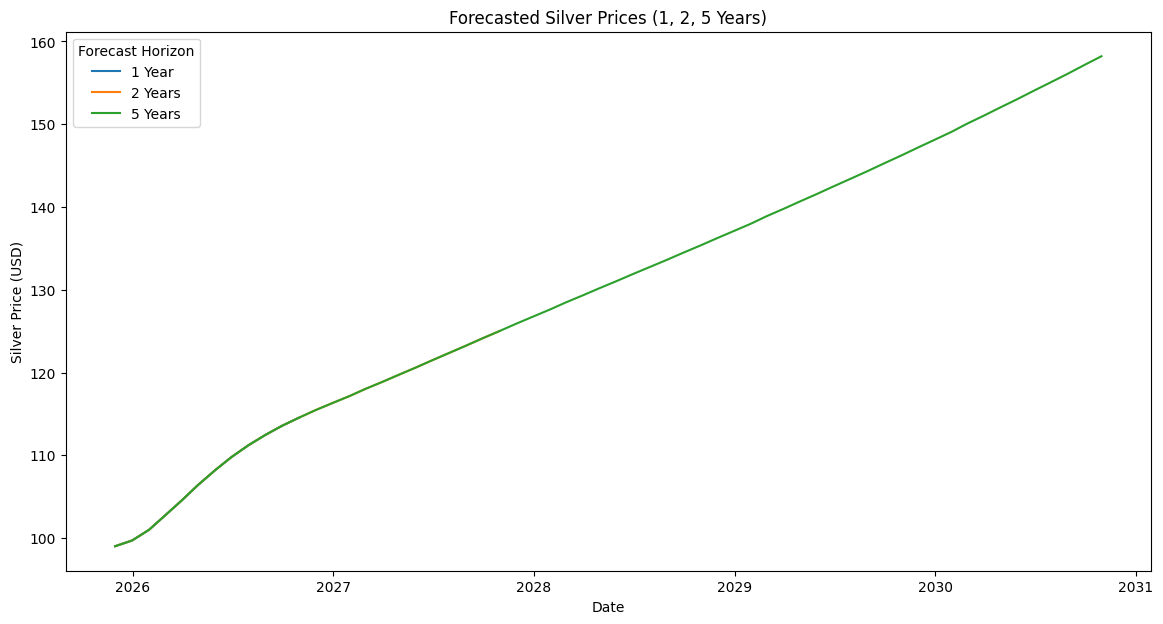

In [ ]:
import seaborn as sns

plt.figure(figsize=(14,7))
sns.lineplot(data=df_all_forecasts, x='Date', y='Silver_Price_USD', hue='Horizon')
plt.title('Forecasted Silver Prices (1, 2, 5 Years)')
plt.xlabel('Date')
plt.ylabel('Silver Price (USD)')
plt.legend(title='Forecast Horizon')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np


In [ ]:
# Assume we already have these variables from previous steps
# df_monthly['silver'] -> historical monthly silver price
# forecast_1yr_orig, forecast_2yr_orig, forecast_5yr_orig -> forecasted prices
# dates_1yr, dates_2yr, dates_5yr -> corresponding forecast dates

# Combine historical + forecast for continuous plotting
dates_all = np.concatenate([df_monthly.index, dates_1yr, dates_2yr, dates_5yr])
prices_all = np.concatenate([
    df_monthly['silver'].values,
    forecast_1yr_orig,
    forecast_2yr_orig,
    forecast_5yr_orig
])


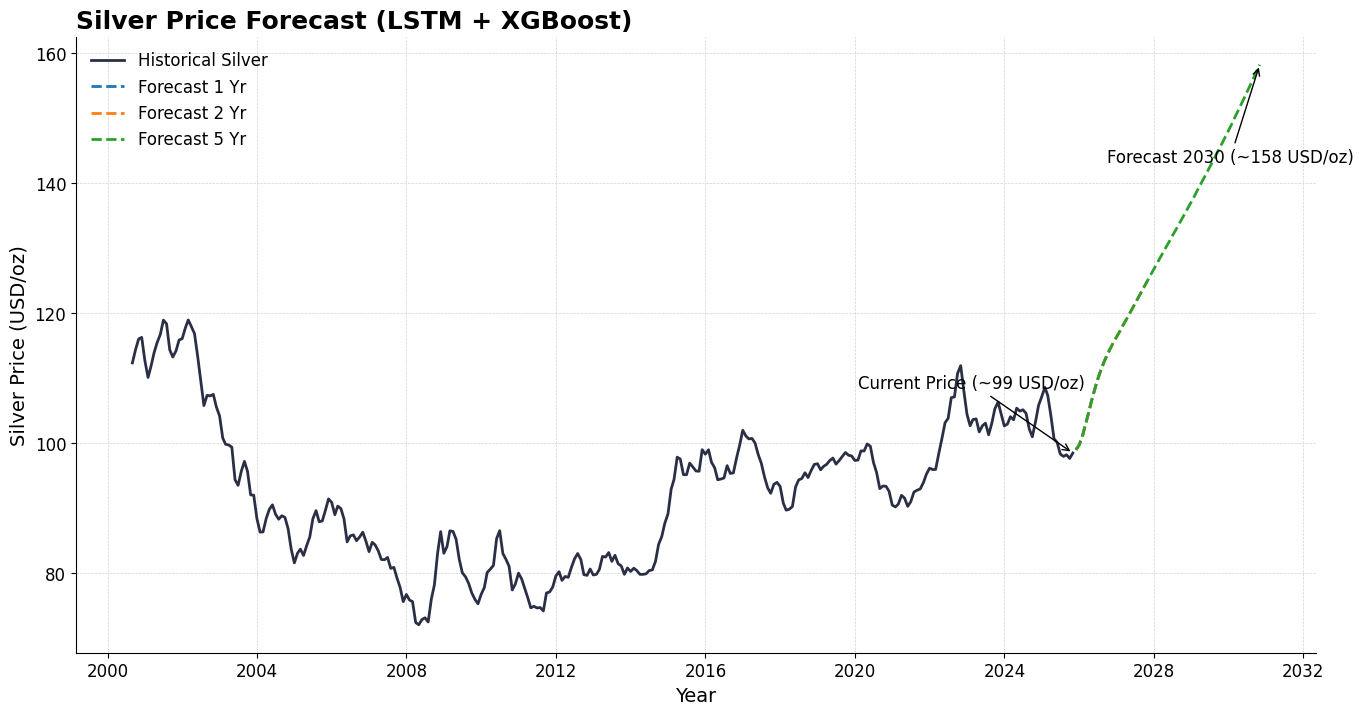

In [ ]:
plt.figure(figsize=(16,8))

# Plot historical prices
plt.plot(df_monthly.index, df_monthly['silver'], label='Historical Silver', color='#2a2f45', linewidth=2)

# Plot forecast horizons
plt.plot(dates_1yr, forecast_1yr_orig, label='Forecast 1 Yr', color='#1f77b4', linestyle='--', linewidth=2)
plt.plot(dates_2yr, forecast_2yr_orig, label='Forecast 2 Yr', color='#ff7f0e', linestyle='--', linewidth=2)
plt.plot(dates_5yr, forecast_5yr_orig, label='Forecast 5 Yr', color='#2ca02c', linestyle='--', linewidth=2)

# Annotations for key points
plt.annotate('Current Price (~99 USD/oz)',
             xy=(df_monthly.index[-1], df_monthly['silver'].values[-1]),
             xytext=(df_monthly.index[-70], df_monthly['silver'].values[-1]+10),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)

plt.annotate('Forecast 2030 (~158 USD/oz)',
             xy=(dates_5yr[-1], forecast_5yr_orig[-1]),
             xytext=(dates_5yr[-50], forecast_5yr_orig[-1]-15),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=12)

# FT-style formatting
plt.title('Silver Price Forecast (LSTM + XGBoost)', fontsize=18, fontweight='bold', loc='left')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Silver Price (USD/oz)', fontsize=14)
plt.grid(color='#d3d3d3', linestyle='--', linewidth=0.5)
plt.legend(frameon=False, fontsize=12)

# Style tweaks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show plot
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Assuming y_test and final_pred are your actual and predicted values
mae = mean_absolute_error(y_test, final_pred)
rmse = np.sqrt(mean_squared_error(y_test, final_pred))
r2 = r2_score(y_test, final_pred)

print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

MAE: 0.003261
RMSE: 0.004411
R²: 0.9985
